# Introduction
Probably, you heard some of the following collocations, namely artificial intelligence, data science, machine learning, etc, etc. I am sure you did. This stuff is so widespread, so popular... because the results of these spheres help us make better decisions based on previously collected data.<br>
In addition, you should understand that there are a lot of options on how to solve these problems. You can choose different tools, different languages, different algorithms. Now I am not going to compare them but just I am trying to go into the Azure Machine Learning Studio details accompanied by Jupyter Notebook with Python.<br>
To be more precise, here we tried to solve the following problem:
we have a dataset with sales values for several years and we try to predict them for the next period of time.

# Import data to Azure Machine Learning Studio
The first step is to download the [dataset](https://community.tableau.com/docs/DOC-1236) and then import it to Azure Machine Learning Studio (next times we will use AMLS).<br>
<ol>
  <li>After downloading a file to your local environment, go to the AMLS to the 'Datasets' section</li>
  <li>Click on New button > From local file</li>
  <li>Upload the file</li>
</ol>
So now let's import these data and look at them.

In [39]:
# This code can be generated from a node of the experiment (the idea was taken from the following link: https://blogs.technet.microsoft.com/machinelearning/2015/07/24/introducing-jupyter-notebooks-in-azure-ml-studio/)
from azureml import Workspace

ws = Workspace()
ds = ws.datasets['Store.csv']
frame = ds.to_dataframe()
frame.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [20]:
# Import all dependencies
import warnings
warnings.filterwarnings('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [21]:
# Here we just fix some issues with Order Date column
df = frame
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
furniture = df.loc[df['Category'] == 'Furniture']

cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
furniture = furniture.set_index('Order Date')

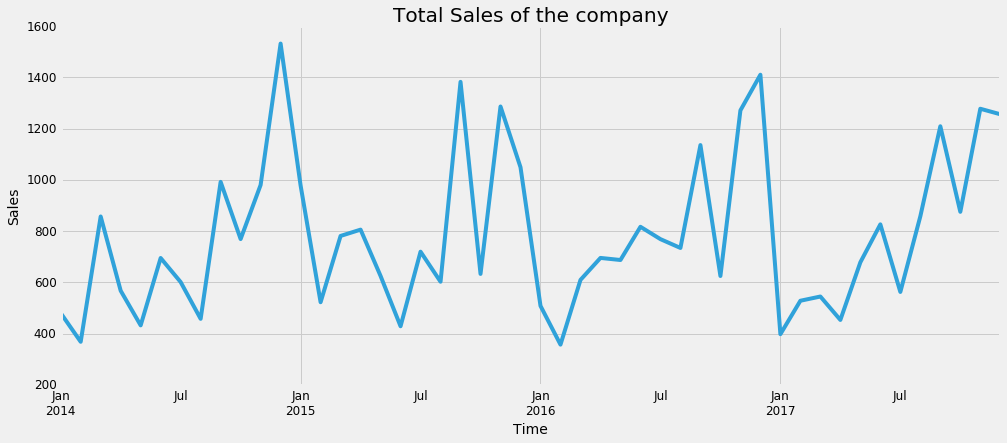

In [22]:
# Get the interested data
y = furniture['Sales'].resample('MS').mean()

y.plot(figsize=(15, 6))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

# Algorithm
As mentioned above we want to predict sales values for the next period of time based on previous values. So, we are interested in 3 columns: Order Date, Category and Sales. Here we will only be working with lines where Category is equal to 'Furniture'.<br>
In the end, we get Sales as a target variable which depend on time. And one of the approaches to deal with such type of problems is using algorithms related to time series.<br>
In a nutshell, time series is the approach to create an autoregression relation. For example, if y is our variable then our aim is to estimate parameters $a_k$ in the equation:
\begin{equation*}
y(t) = \sum_{i=1}^s a_ky(t-i)
\end{equation*}
If you want to go deeper you could follow [a really good article about that](https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3).

The common approach of AMLS is to use the experiment section, but now it has a limited amount of algorithms and there are no time series algorithms. Therefore we are here in the Jupyter notebook and use all power of Python and its library.<br>
So, here we will use the SARIMAX method which takes into account seasonality, trend of data. Next piece of code helps to determine the best model parameters.

In [25]:
#
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            tmp_aic = results.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (param, param_seasonal)
                best_mdl = mod
        except:
            continue
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1417.91027303
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.231443342
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1326.74283482
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.004719912
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.925227076
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.560742981
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.525864592
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:24396.2204956
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.988487695
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1506.30018777
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:497.7889663
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1424.92398996
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:319.771406811
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:649.905617682
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:3013.91784507
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:458.870554848
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:486.183297744
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:3209.65749359
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:310.75

In [26]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


# Results
Now, let's check look at observed and predicted values for short and long periods and make some diagnosis of results, namely determine the mean squared error and the root of the mean squared error.

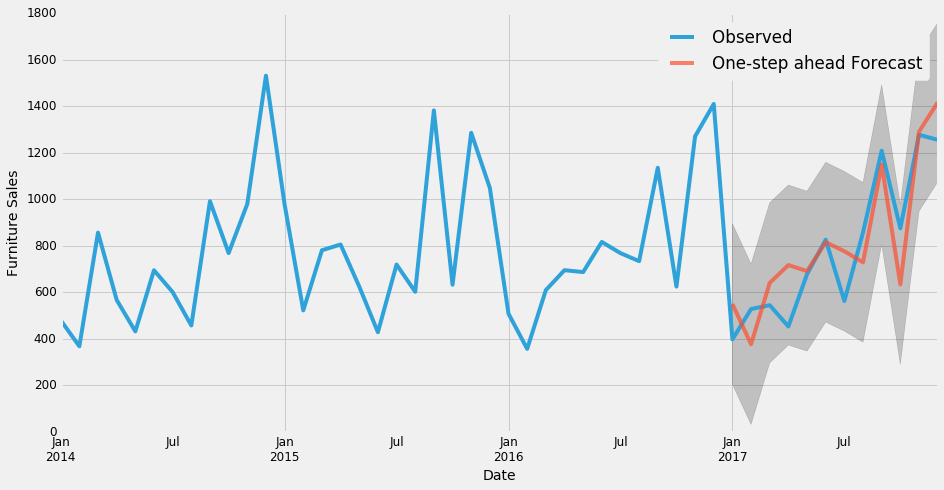

In [31]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

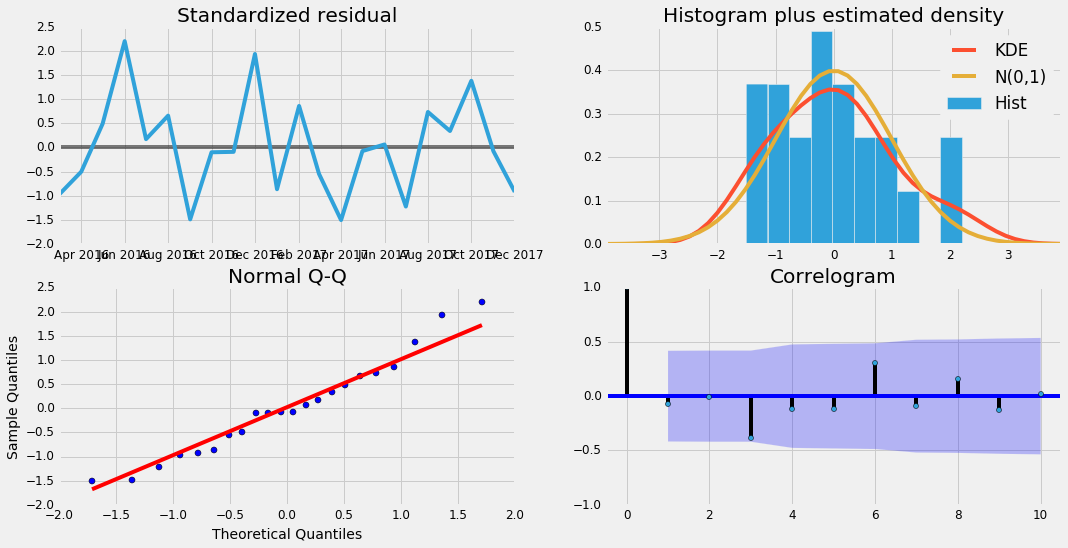

In [33]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

In [34]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [35]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


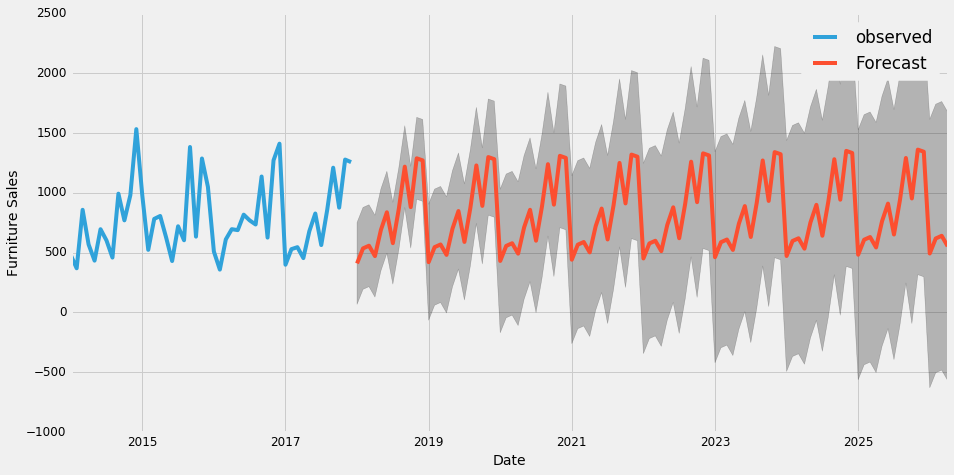

In [36]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

# Conclusion
In this section, I want to emphasis on some strong and weak points of Azure Machine Learning Studio which I have noticed during this experiment to understand the usability of this tool:<br>
<ul>
  <li>AMLS gives you the possibility to be independent on hardware</li>
  <li>Using it there is no need to install data science software with some common libraries, but it might become a pain when it comes to using some specific libraries (you need to install them for every notebook that takes time and they are not always working properly)</li>
  <li>It is great to use the experiment section for fast comparing different approaches but remember that it does not have everything that you and I might want</li>
  <li>For such users we get some additional technologies here in AMLS, for example, Jupyter notebook and it is really great.</li>
  <li>And one of the best features is sharing possibility.</li>
</ul>